# Titanic存活预测

**目录**

1. [概述](#概述)
2. [数据分析](#数据分析)
3. [数据清洗](#数据清洗)
4. [baseline建模及评估](#baseline建模及评估) 
5. [模型融合及评估](#模型融合及评估)
6. [预测及提交](#预测及提交)
7. [总结](#总结)

## 1. 概述<a id='概述'></a>

Titanic存活预测是Kaggle上的入门赛题。给定一些乘客的信息，及其最后是否存活的label，作为训练样本,预测其他乘客是否存活，是典型的二分类问题。

## 2. 数据分析<a id='数据分析'></a>

首先导入数据

In [1]:
import numpy as np
import pandas as pd
import warnings
import matplotlib
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')
%matplotlib inline
import seaborn as sns

In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
all_data = pd.concat([train,test],keys = ['train','test'])

In [3]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
print(train.shape[0],test.shape[0]) #训练集891条，测试集418条

891 418


In [5]:
train['Survived'].mean() #平均存活率38.4%

0.3838383838383838

### Missing Data
年龄与舱位的数据缺失比较严重

In [6]:
total = all_data.drop(['Survived'],axis=1).isnull().sum().sort_values(ascending=False)
percent = (all_data.drop(['Survived'],axis=1).isnull().sum()/all_data.drop(['Survived'],axis=1).isnull().count()).sort_values(ascending=False)
Type = all_data.drop(['Survived'],axis=1).dtypes
pd.concat([total,percent,Type], axis=1, keys=['Total','Percent','Type'])

,Total,Percent,Type
Age,263,0.200917,float64
Cabin,1014,0.774637,object
Embarked,2,0.001528,object
Fare,1,0.000764,float64
Name,0,0.000000,object
Parch,0,0.000000,int64
PassengerId,0,0.000000,int64
Pclass,0,0.000000,int64
Sex,0,0.000000,object
SibSp,0,0.000000,int64


### Pclass

* 3等座人数最多，1等2等差不多
* 等级越高，存活率越高

In [7]:
survived = train[['Pclass','Survived']].groupby(['Pclass'],as_index=False).mean()
count = train[['Pclass','Survived']].groupby(['Pclass'],as_index=False).count()
count.columns = ['Pclass','count']
pd.merge(count,survived,how = 'left', on=['Pclass'])

,Pclass,count,Survived
0,1,216,0.629630
1,2,184,0.472826
2,3,491,0.242363


### Sex
女性生存几率大大高于男性

In [8]:
survived = train[['Sex','Survived']].groupby(['Sex'],as_index=False).mean()
count = train[['Sex','Survived']].groupby(['Sex'],as_index=False).count()
count.columns = ['Sex','count']
pd.merge(count,survived,how = 'left', on=['Sex'])

,Sex,count,Survived
0,female,314,0.742038
1,male,577,0.188908


### Embarked
登船口以S居多，C的存活率较其他两个稍微高一点

In [9]:
survived = train[['Embarked','Survived']].groupby(['Embarked'],as_index=False).mean()
count = train[['Embarked','Survived']].groupby(['Embarked'],as_index=False).count()
count.columns = ['Embarked','count']
pd.merge(count,survived,how ='left', on=['Embarked'])

,Embarked,count,Survived
0,C,168,0.553571
1,Q,77,0.389610
2,S,644,0.336957


### Age
从年龄上看，并没有太大的差别

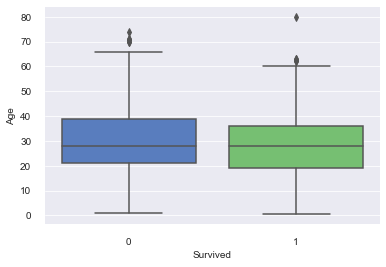

In [10]:
import seaborn as sns
sns.set_style("darkgrid")
sns.boxplot(x="Survived", y="Age", data=train[['Age','Survived']], palette="muted")
sns.despine(offset=10, trim=True)

### Fare
* 票价的范围比较大，最大的超过了500
* 幸存者票价会略高一些

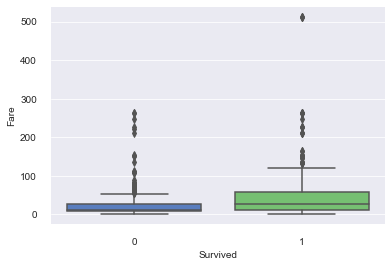

In [11]:
import seaborn as sns
sns.set_style("darkgrid")
sns.boxplot(x="Survived", y="Fare", data=train[['Fare','Survived']], palette="muted")
sns.despine(offset=10, trim=True)

## 3. 数据清洗<a id='数据清洗'></a>

首先处理缺失数据。对于乘客的年龄，考虑到其年龄可能会与其称谓头衔有关，故先从Name字段中提炼出头衔，并对一些少数的特殊称谓汇总。

In [12]:
all_data['Title'] = all_data.Name.str.extract(' ([A-Za-z]+)\.', expand=False)

Title_Dictionary = {
                    "Capt":       "Officer",
                    "Col":        "Officer",
                    "Major":      "Officer",
                    "Jonkheer":   "Royalty",
                    "Don":        "Royalty",
                    "Sir" :       "Royalty",
                    "Dr":         "Officer",
                    "Rev":        "Officer",
                    "Countess":   "Royalty",
                    "Dona":       "Royalty",
                    "Mme":        "Mrs",
                    "Mlle":       "Miss",
                    "Ms":         "Mrs",
                    "Mr" :        "Mr",
                    "Mrs" :       "Mrs",
                    "Miss" :      "Miss",
                    "Master" :    "Master",
                    "Lady" :      "Royalty"
                    }
all_data['Title'] = all_data.Title.map(Title_Dictionary)

### Title
Mrs和Miss的存活率还是蛮高的，Mr就比较悲剧，这跟性别有很大关系

In [13]:
survived = all_data.ix[:train.shape[0],['Title','Survived']].groupby(['Title'], as_index = False).mean()
count = all_data.loc['train',['Title','Survived']].groupby(['Title'], as_index = False).count()
count.columns = ['Title','count']
pd.merge(count,survived,how ='left', on=['Title'])

,Title,count,Survived
0,Master,40,0.575000
1,Miss,184,0.701087
2,Mr,517,0.156673
3,Mrs,127,0.795276
4,Officer,18,0.277778
5,Royalty,5,0.600000


* 不同Title的平均年龄还是有较大区别的

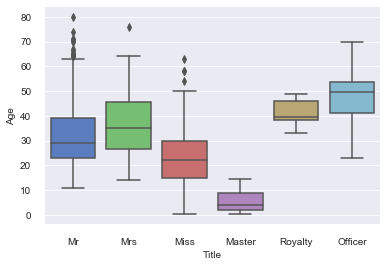

In [14]:
import seaborn as sns
sns.set_style("darkgrid")
sns.boxplot(x="Title", y="Age", data=all_data[['Title','Age']], palette="muted")
sns.despine(offset=10, trim=True)

* 不同等级仓位的平均年龄也有一定区别

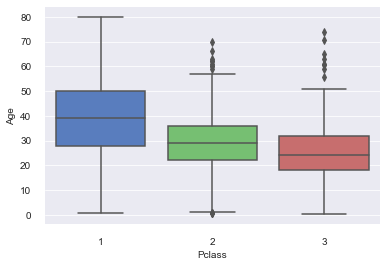

In [15]:
import seaborn as sns
sns.set_style("darkgrid")
sns.boxplot(x="Pclass", y="Age", data=all_data[['Pclass','Age']], palette="muted")
sns.despine(offset=10, trim=True)

基于以上两个属性，对缺失的年龄进行分组填充

In [16]:
age_df=all_data.loc[:,['Title','Pclass','Age']].groupby(['Pclass','Title'],as_index=False).mean()
age_df['Age'] = round(age_df['Age'])
age_df.rename(columns={'Age':'Age_p'},inplace = True)
all_data = pd.merge(all_data, age_df, how='left', on=['Title', 'Pclass'])
all_data['Age'].where(all_data['Age'].notnull(),all_data['Age_p'],inplace = True)
all_data.drop(['Age_p'],axis = 1,inplace = True)

### Cabin
cabin因为缺失值过多，所以令缺失值为0，反之为1

In [17]:
all_data['Cabin'].loc[all_data['Cabin'].isnull()]=0
all_data['Cabin'].loc[all_data['Cabin']!=0]=1
all_data['Cabin']=all_data['Cabin'].astype(int)

Embarked和Fare的缺失值都分别填上众数和平均数

In [18]:
freq_port = all_data.Embarked.dropna().mode()[0]
all_data['Embarked'] = all_data['Embarked'].fillna(freq_port)
all_data['Fare'].fillna(all_data['Fare'].mean(),inplace = True)

再次检查缺失值

In [19]:
total = all_data.drop(['Survived'],axis=1).isnull().sum().sort_values(ascending=False)
percent = (all_data.drop(['Survived'],axis=1).isnull().sum()/all_data.drop(['Survived'],axis=1).isnull().count()).sort_values(ascending=False)
Type = all_data.drop(['Survived'],axis=1).dtypes
pd.concat([total,percent,Type], axis=1, keys=['Total','Percent','Type'])

,Total,Percent,Type
Age,0,0.0,float64
Cabin,0,0.0,int64
Embarked,0,0.0,object
Fare,0,0.0,float64
Name,0,0.0,object
Parch,0,0.0,int64
PassengerId,0,0.0,int64
Pclass,0,0.0,int64
Sex,0,0.0,object
SibSp,0,0.0,int64


### FamilySize
增加家庭成员人数字段

In [20]:
all_data['FamilySize'] = all_data['SibSp'] + all_data['Parch'] + 1

删掉不用的字段

In [21]:
all_data.drop(['PassengerId','Name','SibSp','Parch','Ticket'],axis = 1,inplace = True)

In [22]:
all_data.dtypes

Age           float64
Cabin           int64
Embarked       object
Fare          float64
Pclass          int64
Sex            object
Survived      float64
Title          object
FamilySize      int64
dtype: object

对数据进行必要的处理，为喂入模型做准备

In [23]:
all_data['Sex'].loc[all_data['Sex']=='male']=0
all_data['Sex'].loc[all_data['Sex']=='female']=1
all_data['Sex'] = all_data['Sex'].astype(int)

In [24]:
df_x=all_data.drop(['Survived'],axis = 1)

In [25]:
df_x=pd.get_dummies(df_x)

In [26]:
from scipy import stats
df_x[['Age','Fare']].apply(lambda x: stats.skew(x))

Age     0.452129
Fare    4.364366
dtype: float64

Fare偏度过大，将其取对数

In [27]:
df_x['Fare'] = np.log1p(df_x['Fare'])

将所有数据标准化

In [28]:
from sklearn.preprocessing import MinMaxScaler
df_x=pd.DataFrame(MinMaxScaler().fit_transform(df_x),columns=df_x.columns)

In [29]:
df_x.describe()

,Age,Cabin,Fare,Pclass,Sex,FamilySize,Embarked_C,Embarked_Q,Embarked_S,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Officer,Title_Royalty
count,1309.000000,1309.000000,1309.000000,1309.000000,1309.000000,1309.000000,1309.000000,1309.000000,1309.000000,1309.000000,1309.000000,1309.000000,1309.000000,1309.000000,1309.000000
mean,0.366910,0.225363,0.477467,0.647441,0.355997,0.088388,0.206264,0.093965,0.699771,0.046600,0.200153,0.578304,0.152788,0.017571,0.004584
std,0.168089,0.417981,0.155173,0.418918,0.478997,0.158364,0.404777,0.291891,0.458533,0.210862,0.400267,0.494019,0.359921,0.131435,0.067573
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.260929,0.000000,0.350202,0.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.348616,0.000000,0.438698,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
75%,0.455092,0.000000,0.556696,1.000000,1.000000,0.100000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


数据切分

In [30]:
x_train = df_x[:train.shape[0]]
x_test = df_x[train.shape[0]:]
y_train = train['Survived']

## 4. baseline建模及评估<a id='baseline建模及评估'></a>

本次准备尝试LR,SVM,KNN,RF,Xgboost

In [31]:
from sklearn.model_selection import learning_curve
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid(True)

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

In [32]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
import time
def kfold_plot(train, ytrain, model):
    kf = StratifiedKFold(n_splits=5)
    accuracy_scores = []
    exe_time = []
 
    i=0
    for train_index, test_index in kf.split(train, ytrain):
        X_train, X_test = train.iloc[train_index], train.iloc[test_index]
        y_train, y_test = ytrain.iloc[train_index], ytrain.iloc[test_index]
        begin_t = time.time()
        model.fit(X_train, y_train)
        predictions = model.predict(X_test)
        end_t = time.time()
        exe_time.append(round(end_t-begin_t, 3))      
        
        accuracy_scores.append(accuracy_score(y_test.astype(float), predictions)) 
        
        i += 1

    print ('mean accuracy_scores: ', np.mean(accuracy_scores))
    print ('mean model process time: ', np.mean(exe_time), 's')
    plot_learning_curve(model, "Learning Curves",train, ytrain, ylim=(0.1, 1.01), n_jobs=1,cv=10)
    plt.show()
    return np.mean(accuracy_scores),np.mean(exe_time)

In [33]:
mean_accuracy = {}
mean_time = {}

### Logistic Regression

mean accuracy_scores:  0.827184216396
mean model process time:  0.0028 s


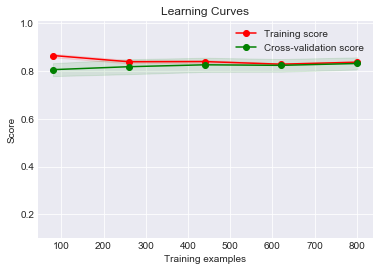

In [34]:
from sklearn.linear_model import LogisticRegression
lr_model = LogisticRegression(C=100)
mean_accuracy['lr'],mean_time['lr'] = kfold_plot(x_train, y_train, lr_model)

### SVM

mean accuracy_scores:  0.823832261089
mean model process time:  0.02 s


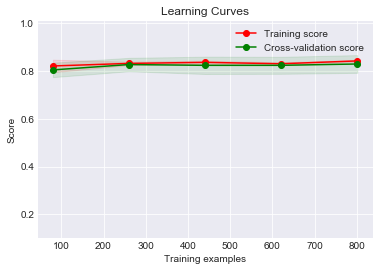

In [35]:
from sklearn.svm import SVC
svc_model = SVC(C=20)
mean_accuracy['svc'],mean_time['svc'] = kfold_plot(x_train, y_train, svc_model)

### KNN

mean accuracy_scores:  0.805873209572
mean model process time:  0.0078 s


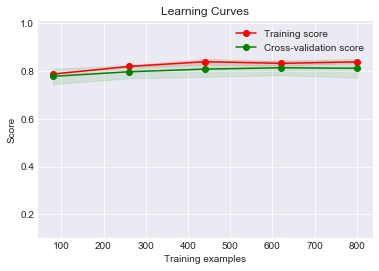

In [36]:
from sklearn.neighbors import KNeighborsClassifier
knn_model = KNeighborsClassifier(n_neighbors=10)
mean_accuracy['knn'],mean_time['knn'] = kfold_plot(x_train, y_train, knn_model)

### Random Forest

mean accuracy_scores:  0.826035299829
mean model process time:  0.0182 s


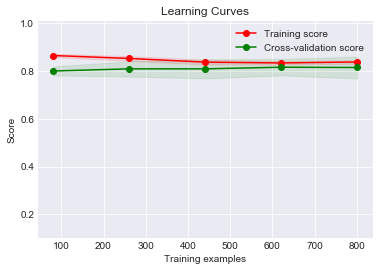

In [37]:
from sklearn.ensemble import RandomForestClassifier
rf_model = RandomForestClassifier(max_depth = 4,random_state=42)
mean_accuracy['rf'],mean_time['rf'] = kfold_plot(x_train, y_train, rf_model)

### Xgboost

/Users/jinxinzhe/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


mean accuracy_scores:  0.835036830796
mean model process time:  0.011 s


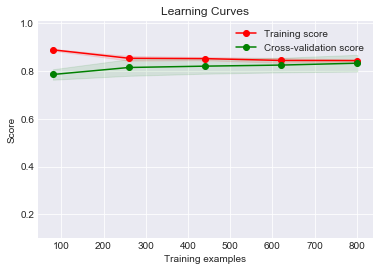

In [38]:
from xgboost.sklearn import XGBClassifier
xgb_model = XGBClassifier(learning_rate =0.1, n_estimators=20, max_depth=3,\
        min_child_weight=1, gamma=0,subsample=0.9,colsample_bytree=0.9,\
        objective= 'binary:logistic',scale_pos_weight=1, seed=27)
mean_accuracy['xgb'],mean_time['xgb'] = kfold_plot(x_train, y_train, xgb_model)

### 模型对比

In [39]:
df_eval={"model" : list(mean_accuracy.keys()),
                  "accuracy" : list(mean_accuracy.values())}
df_eval=pd.DataFrame(df_eval,columns=["model","accuracy"])
df_eval.sort_values("accuracy",ascending=False)

,model,accuracy
4,xgb,0.835037
0,lr,0.827184
3,rf,0.826035
1,svc,0.823832
2,knn,0.805873


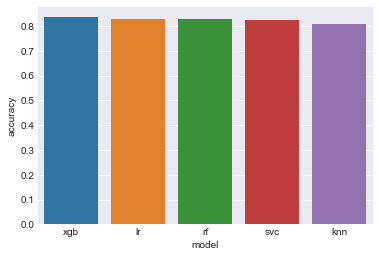

In [40]:
import seaborn as sns
sns.set_style("darkgrid")
ax = sns.barplot(x="model", y="accuracy", data=df_eval.sort_values("accuracy",ascending=False))

可以看到，模型之间并没有很大的差距；效果最好的是xgboost，knn的效果相对较差

## 5. 模型融合及评估<a id='模型融合及评估'></a>

排除分数相对较低的knn，将模型stack一下

mean accuracy_scores:  0.836147872162
mean model process time:  0.0566 s


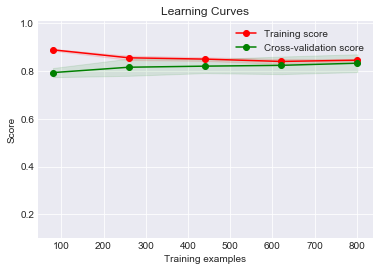

In [41]:
from mlxtend.classifier import StackingClassifier
from sklearn.model_selection import cross_val_score
sclf_model = StackingClassifier(classifiers=[lr_model, svc_model, rf_model, xgb_model],meta_classifier=LogisticRegression())
mean_accuracy['stack'],mean_time['stack'] = kfold_plot(x_train, y_train, sclf_model)

In [42]:
df_eval={"model" : list(mean_accuracy.keys()),
                  "accuracy" : list(mean_accuracy.values())}
df_eval=pd.DataFrame(df_eval,columns=["model","accuracy"])
df_eval.sort_values("accuracy",ascending=False)

,model,accuracy
5,stack,0.836148
4,xgb,0.835037
0,lr,0.827184
3,rf,0.826035
1,svc,0.823832
2,knn,0.805873


stack后模型效果好了那么一丢丢。。。

## 6. 预测及提交<a id='预测及提交'></a>

In [43]:
sclf_model.fit(x_train, y_train)
y = sclf_model.predict(x_test) 
obj = pd.Series(y,name = 'Survived')
result = pd.concat([test['PassengerId'],obj],axis=1)
result.to_csv('result_stack.csv',index = False)

![](titanic_score.png)

## 7. 总结<a id='总结'></a>

1. 因为是Kaggle的入门练习赛,所以数据量和维度都不是很大;
2. 除非是有非常大的把握,不然不要轻易把连续特征离散化(如这里的Age,Fare),否则很容易造成过拟合;
3. 基于第1条总结,本次没有对模型进行gridsearch调优,也没有必要为了提升最后的一点分数花太多的精力,因为该赛题本身不具有数据挖掘问题的普遍性,但从另一方面来说,比较适合拿来练习各种工具包如pandas,numpy,matplotib,seaborns,sklearn,尝试各种算法及个人idea;
4. xgboost在这类问题上还是非常好用的;
5. 一般一个完整的流程,会在baseline模型完成后进行一次初步的提交试探成绩,以及进行人工误差分析;从分析结果中的到一些新的想法,进一步优化特征工程以及模型,再进行提交...是一个迭代的过程。这边因为数据集比较简少,所以省略了迭代的过程。